Assignment 3 - Q3

In [2]:
# Load the Drive helper and mount
from google.colab import drive
import os

# This will prompt for authorization.
drive.mount('/content/drive')


os.chdir('drive/My Drive/IFT-6135/IFT6135H19_assignment/assignment3')
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/IFT-6135/IFT6135H19_assignment/assignment3


In [3]:
!pwd
!ls -la



/content/drive/My Drive/IFT-6135/IFT6135H19_assignment/assignment3
total 5259
drwx------ 2 root root    4096 Apr 16 19:32 binarized_mnist
-rw------- 1 root root    4198 Apr 15 18:19 classify_svhn.py
-rw------- 1 root root    1737 Apr 15 18:19 density_estimation.py
-rw------- 1 root root    5978 Apr 16 21:08 GAN.py
drwx------ 2 root root    4096 Apr 16 19:32 .idea
drwx------ 2 root root    4096 Apr 16 19:32 .ipynb_checkpoints
-rw------- 1 root root   27231 Apr 16 19:32 mnist_loader.ipynb
drwx------ 2 root root    4096 Apr 15 18:25 __pycache__
-rw------- 1 root root   18238 Apr 16 21:12 q3_GAN.ipynb
-rw------- 1 root root   23575 Apr 16 19:32 q3.ipynb
drwx------ 2 root root    4096 Apr 15 20:11 sample_1
drwx------ 2 root root    4096 Apr 15 22:01 sample_2
-rw------- 1 root root     923 Apr 15 18:19 samplers.py
-rw------- 1 root root    3372 Apr 15 18:19 score_fid.py
drwx------ 2 root root    4096 Apr 15 18:19 svhn
-rw------- 1 root root 1501617 Apr 15 18:19 svhn_classifier.pt
-rw------- 

In [4]:
import torch
from torch import nn
import torchvision
from torch.autograd import  Variable
from torch import optim
from classify_svhn import get_data_loader

import GAN  # needed to allow the reload
import importlib
importlib.reload(GAN)
from GAN import Generator, Discriminator, DGAN_initialization

import matplotlib.pyplot as plt

lr = 0.0002
betas = (0.5, 0.999)
batch_size = 128
z_size = 100
im_size = 32
n_critic = 5
num_epoch = 10

if torch.cuda.is_available():
    print("Using cuda")
    device = torch.device("cuda")
else:
    print("Running on cpu")
    device = torch.device("cpu")
    
G = Generator(z_size).to(device)
D = Discriminator(im_size, device).to(device)

DGAN_initialization(G)
DGAN_initialization(D)

g_optim = optim.Adam(G.parameters(), lr=lr, betas=betas)
d_optim = optim.Adam(D.parameters(), lr=lr, betas=betas)

Using cuda


Data

In [5]:
train_loader, valid_loader, test_loader = get_data_loader("svhn", batch_size)

Using downloaded and verified file: svhn/train_32x32.mat
Using downloaded and verified file: svhn/test_32x32.mat


tensor(3)


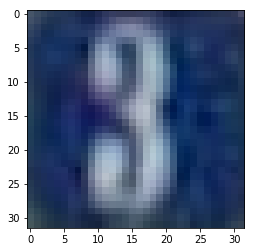

In [6]:
def showImg(x):
    x = x.permute(1, 2, 0)
    plt.imshow((x.detach().cpu().numpy() * 0.5) + 0.5)
    
def saveImg(x, name):
  save_dir = 'sample/'
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
  x = x * 0.5 + 0.5
  torchvision.utils.save_image(x, save_dir+name)
    
# Show an image
real_sample, target = next(iter(train_loader))

showImg(real_sample[0])
print(target[0])

In [0]:
def train(loader):
    d_train_loss = 0
    
    for epoch in range(num_epoch):
        
        for data_idx, real_sample in enumerate(loader):
            G.train()
            D.train()
            
            step = epoch * len(loader) + data_idx + 1
            
            # Train more the dicriminator
            d_optim.zero_grad()
            g_optim.zero_grad()
    
            z = Variable(torch.randn(real_sample[0].shape[0], z_size, device=device))
            
            fake_sample = G(z)
            real_sample = real_sample[0].to(device)
            
            d_loss = D.loss(real_sample, fake_sample)
            d_loss.backward()
            d_train_loss += d_loss.item()
            d_optim.step()
    
            if step % n_critic == 0:
                # Train the generator
                d_optim.zero_grad()
                g_optim.zero_grad()
            
                z = Variable(torch.randn(batch_size, z_size, device=device))
            
                fake_sample = G(z)
                fake_result = D(fake_sample)
                g_loss = G.loss(fake_result)
                g_loss.backward()
                g_optim.step()
                
        print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, d_train_loss / len(loader.dataset)))
        name = 'epoch_'+str(epoch)+'.jpg'
        createSample(G, name)

In [0]:

z_sample = Variable(torch.randn(3, z_size, device=device))

def createSample(generator, name):
    generator.eval()
    
    im = generator(z_sample)
    saveImg(im, name)
    

In [9]:
train(train_loader)

====> Epoch: 0 Average loss: 0.0192
====> Epoch: 1 Average loss: 0.0048
====> Epoch: 2 Average loss: -0.0105
====> Epoch: 3 Average loss: -0.0259
====> Epoch: 4 Average loss: -0.0417
====> Epoch: 5 Average loss: -0.0574
====> Epoch: 6 Average loss: -0.0740
====> Epoch: 7 Average loss: -0.0918
====> Epoch: 8 Average loss: -0.1108
====> Epoch: 9 Average loss: -0.1300
